In [1]:
import os
os.chdir("/Users/aarsh/Desktop/Autonomous Vehicles/tracking_course-master/Final_Project")
!ls

Images                             final_project_Starter.ipynb
RealTimeMultipleObjectTracking.pdf yolo_for_tracking.py
__pycache__                        yolo_nms.py
final_project.ipynb


In [2]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import copy
import pickle
import cv2
from yolo_nms import *

# Loading The Data
This contains a series of images from a video, 1 frame per 7 frames is chosen

In [3]:
dataset_images = pickle.load(open('/Users/aarsh/Desktop/Autonomous Vehicles/tracking_course-master/Final_Project/Images/images_tracking.p', "rb"))

Declared a class which will contain 4 parameters for each bounding box , which will be matched with the next frame's bounding boxes.

In [4]:
class Obstacle():
    def __init__(self, idx, box, age=1, unmatched_age=0):
        self.idx = idx
        self.box = box
        self.age=age
        self.unmatched_age=unmatched_age

In [5]:
def id_to_color(id):
    blue = id*5 % 256
    green = id*36 %256
    red = id*23 %256
    return (red, green, blue)

# Calculating IOU's

In [6]:
def convert_data(box):
    """
    Convert data from (x1,y1, w, h) to (x1,y1,x2,y2)
    """
    x1 = box[0]
    x2 = box[0] + box[2]
    y1 = box[1]
    y2 = box[1]+box[3]
    return x1,y1,x2,y2

def box_iou(box1, box2):
    """
    Computer Intersection Over Union cost
    """
    box1 = convert_data(box1)
    box2 = convert_data(box2)
    xA = max(box1[0], box2[0])
    yA = max(box1[1], box2[1])
    xB = min(box1[2], box2[2])
    yB = min(box1[3], box2[3])

    inter_area = max(0, xB - xA + 1) * max(0, yB - yA + 1) #abs((xi2 - xi1)*(yi2 - yi1))
    # Calculate the Union area by using Formula: Union(A,B) = A + B - Inter(A,B)
    box1_area = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1) #abs((box1[3] - box1[1])*(box1[2]- box1[0]))
    box2_area = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1) #abs((box2[3] - box2[1])*(box2[2]- box2[0]))
    union_area = (box1_area + box2_area) - inter_area
    # compute the IoU
    iou = inter_area/float(union_area)
    return iou

# Cost 

Calculated as proposed in this [paper](https://arxiv.org/pdf/1709.03572.pdf)


In [7]:
from scipy.optimize import linear_sum_assignment

def check_division_by_zero(value,epsilon=0.01):
  if value<epsilon:
    value = epsilon
  return value

def hungarian_cost(old_box, new_box, iou_thresh = 0.3, linear_thresh = 10000, exp_thresh = 0.5):
        w1 = 0.5
        w2 = 1.5
        (_, h, w, _) = np.array(dataset_images).shape
        # IOU COST
        iou_cost = box_iou(old_box, new_box)
        
        # Sanchez-Matilla et al COST
        Q_dist = np.sqrt(pow(w,2)+pow(h,2)) 
        Q_shape = w*h
        distance_term = Q_dist/check_division_by_zero(np.sqrt(pow(old_box[0] - new_box[0], 2)+pow(old_box[1] -new_box[1],2)))
        shape_term = Q_shape/check_division_by_zero(np.sqrt(pow(old_box[2] - new_box[2], 2)+pow(old_box[3] - new_box[3],2)))
        linear_cost = distance_term*shape_term

        # exponential cost
        a= (old_box[0] - new_box[0])/check_division_by_zero(old_box[2])
        a_2 = pow(a,2)
        b = (old_box[1] - new_box[1])/check_division_by_zero(old_box[3])
        b_2 = pow(b,2)
        ab = (a_2+b_2)*w1*(-1)
        c = abs(old_box[3] - new_box[3])/(old_box[3]+new_box[3])
        d = abs(old_box[2]-new_box[2])/(old_box[2]+new_box[2])
        cd = (c+d)*w2*(-1)
        exponential_cost = np.exp(ab)*np.exp(cd)

        if (iou_cost >= iou_thresh and linear_cost>=linear_thresh and exponential_cost>=exp_thresh):
            return iou_cost
        else :
            return 0

# Association

In [8]:
def associate(old_boxes, new_boxes):
    # Define a new IOU Matrix nxm with old and new boxes
    iou_matrix = np.zeros((len(old_boxes),len(new_boxes)),dtype=np.float32)

    # Go through boxes and store the IOU value for each box 
    for i,old_box in enumerate(old_boxes):
        for j,new_box in enumerate(new_boxes):
            #iou_matrix[i][j] = box_iou(old_box, new_box)
            iou_matrix[i][j] = hungarian_cost(old_box, new_box)
    # Call for the Hungarian Algorithm
    hungarian_row, hungarian_col = linear_sum_assignment(-iou_matrix)
    hungarian_matrix = np.array(list(zip(hungarian_row, hungarian_col)))

    # Create new unmatched lists for old and new boxes
    matches, unmatched_detections, unmatched_trackers = [], [], []

    # Go through the Hungarian Matrix, if matched element has IOU < threshold (0.3), add it to the unmatched 
    # Else: add the match    
    for h in hungarian_matrix:
        if(iou_matrix[h[0],h[1]]<0.3):
            unmatched_trackers.append(old_boxes[h[0]])
            unmatched_detections.append(new_boxes[h[1]])
        else:
            matches.append(h.reshape(1,2))
    
    if(len(matches)==0):
        matches = np.empty((0,2),dtype=int)
    else:
        matches = np.concatenate(matches,axis=0)
    
    # Go through old boxes, if no matched detection, add it to the unmatched_old_boxes
    for t,trk in enumerate(old_boxes):
        if (hungarian_matrix.size==0):
            continue
        if(t not in hungarian_matrix[:,0]):
            unmatched_trackers.append(trk)
        
        # Go through new boxes, if no matched tracking, add it to the unmatched_new_boxes
    for d, det in enumerate(new_boxes):
        if ((hungarian_matrix.size)==0):
            continue
        if(d not in hungarian_matrix[:,1]):
            unmatched_detections.append(det)
        
    return matches, unmatched_detections,unmatched_trackers

Need to take care for the **False Positives** and the **False Negatives**

In [9]:
#If the detector detects something once and it is not displayed. If it detects it twice in a row, or 3 times in a row it is displayed. Can choose any value
MIN_HIT_STREAK = 2 
#If an obstacle is suddently unmatched, we keep displaying it. If it is unmatched again, or more times, remove it
MAX_UNMATCHED_AGE = 2 

# Tracking

In [10]:
def main(input_image):

    global stored_obstacles # Will be used to keep track of obstacles information
    global idx # Will be used to keep track of id information
    # Run obstacle detection
    image = copy.deepcopy(input_image)
    _, out_boxes = yolo.inference(input_image)
    

    # On first iteration, we only create obstacles with age=1
    if (idx == 0):
        stored_obstacles = []
        for i, box in enumerate(out_boxes):
            obs = Obstacle(idx, box) # Create an obstacle with age=1
            stored_obstacles.append(obs)                
            idx +=1
        return image
    # On this case, if the obstacle has already been matched,  display it depending on the MIN_HIT_STREAK variable
    elif (idx != 0):  #already have obstacles from previous frame, work on association
        # Before calling associate, must create a list of old obstacles
        old_obstacles = [obs.box for obs in stored_obstacles] 
        matches, unmatched_detections, unmatched_tracks = associate(old_obstacles, out_boxes)
        
        selected_obstacles = []
        # Loop through all matches and add these as obstacles
        new_obstacles = []
        for match in matches:
            obs = Obstacle(stored_obstacles[match[0]].idx, out_boxes[match[1]], stored_obstacles[match[0]].age +1) # Increase the age by 1
            new_obstacles.append(obs)
            if obs.age >= MIN_HIT_STREAK:
                selected_obstacles.append(obs)
        
        # Loop through all unmatched detections and add these as obstacles
        for new_obs in unmatched_detections:
            idx +=1
            obs = Obstacle(idx, new_obs)
            new_obstacles.append(obs)
            if obs.age >= MIN_HIT_STREAK:
                selected_obstacles.append(obs)

        for i, old_obs in enumerate(unmatched_tracks):
            if stored_obstacles[i].box == old_obs:
                obs = stored_obstacles[i] 
                obs.unmatched_age +=1
                if obs.unmatched_age <= MAX_UNMATCHED_AGE:
                    selected_obstacles.append(obs)

        # Draw on selected obstacles only
        for i, obs in enumerate(selected_obstacles):
            left, top, right, bottom = convert_data(obs.box)
            cv2.rectangle(image, (left, top), (right, bottom), id_to_color(obs.idx), thickness=5)
            image = cv2.putText(image, str(obs.idx),(left,top),cv2.FONT_HERSHEY_SIMPLEX, 1,id_to_color(obs.idx),thickness=2)                

        stored_obstacles = copy.deepcopy(new_obstacles)
        return image

# Results

8 8
8 7
7 7
7 12
12 9
9 10
10 8
8 10


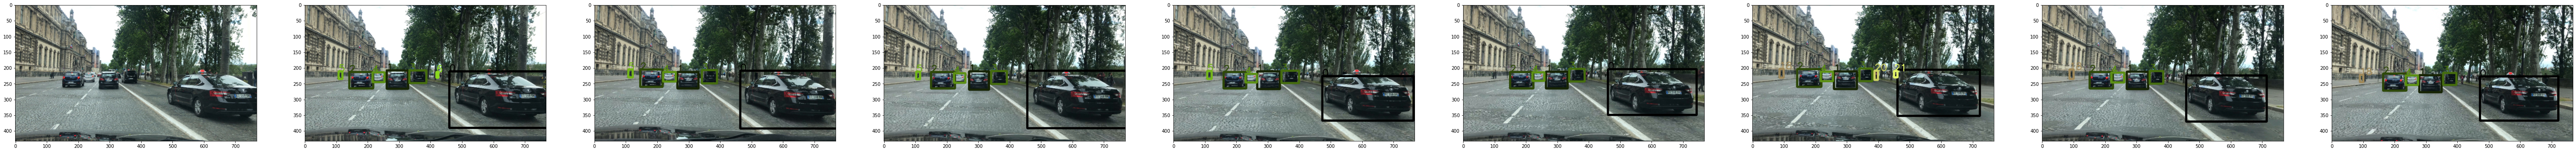

In [11]:
yolo = YOLO()
idx = 0
fig=plt.figure(figsize=(100,100))
result_images_3 = copy.deepcopy(dataset_images)
out_imgs = []

for i in range(len(result_images_3)):
    out_img = main(result_images_3[i])
    out_imgs.append(out_img)
    fig.add_subplot(1, len(result_images_3), i+1)
    plt.imshow(out_imgs[i])
plt.show()
# the objects have been tracked in all the 7 frames

In [12]:
from moviepy.editor import VideoFileClip
idx = 0
detector = YOLO()
video_file = "/Users/aarsh/Desktop/Autonomous Vehicles/tracking_course-master/Final_Project/Images/MOT16-13-raw.mp4" #25 FPS
clip = VideoFileClip(video_file).subclip(0,30)
white_clip = clip.fl_image(main)
%time white_clip.write_videofile("/Users/aarsh/Desktop/result_tracking3.mp4",audio=False)

1
t:  79%|███████▊  | 707/900 [05:59<01:42,  1.89it/s, now=None]0 2


KeyboardInterrupt: 